<a href="https://colab.research.google.com/github/engineerJPark/EECS-498-007/blob/master/Assignment/A5/two_stage_detector_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two-Stage Object Detector
In this exercise you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), which consists of two modules, Region Proposal Networks (RPN) and Fast R-CNN. We will later use it to train a model that can detect objects on novel images and evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Getting Started

## Install starter code
We will continue using the utility functions that we've used for previous assignments: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-wq78h_k9
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-wq78h_k9
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10323 sha256=5f718228565853bd7e5d208e0d905dff72adeeffbf0caec9c24d73e2c815ab75
  Stored in directory: /tmp/pip-ephem-wheel-cache-og5i1hq2/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks, \
                    fix_random_seed, rel_error
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git

Cloning into 'mAP'...
remote: Enumerating objects: 880, done.
remote: Total 880 (delta 0), reused 0 (delta 0), pack-reused 880
Receiving objects: 100% (880/880), 14.70 MiB | 13.30 MiB/s, done.
Resolving deltas: 100% (304/304), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Import functions from previous notebook
Like what you have seen in the previous assignment, this notebook will re-use some pieces of code that you implemented in the previous notebook.

In order to do this, you will need the **Google Drive file ID** of your completed notebook `single_stage_detector_yolo.ipynb`. You can find the this file ID by doing the following:
1. Make sure you have saved your completed `single_stage_detector_yolo.ipynb` notebook to your own Google Drive
2. Open you finished `single_stage_detector_yolo.ipynb` notebook in Colab.
3. Click the "Share" button at the top of the screen
4. Copy the "Notebook link" and paste it in the following cell, assigning it to the `YOLO_NOTEBOOK_LINK` variable

**Important:** If you modify the implementations of any functions in your `single_stage_detector_yolo.ipynb` notebook, **they will not automatically be propagated to this notebook**. For changes to `single_stage_detector_yolo.ipynb` to be propagated to this notebook, you will need to:
1. Make sure that you save your modified `single_stage_detector_yolo.ipynb` notebook (File > Save)
2. Restart the runtime of this notebook (Runtime > Restart Runtime)
3. Rerun all cells in this notebook (in particular the import cell below)

In [ ]:
YOLO_NOTEBOOK_LINK = "https://colab.research.google.com/drive/1hkD5GWWRA5BGD0bhvpUSzOn0Uc5E_RLx"

fcn_id = extract_drive_file_id(YOLO_NOTEBOOK_LINK)
print('Google Drive file id: "%s"' % fcn_id)
register_colab_notebooks({'single_stage_detector_yolo': fcn_id})

from single_stage_detector_yolo import data_visualizer, FeatureExtractor
from single_stage_detector_yolo import get_pascal_voc2007_data, pascal_voc2007_loader
from single_stage_detector_yolo import coord_trans, GenerateGrid, GenerateAnchor, GenerateProposal
from single_stage_detector_yolo import IoU, ReferenceOnActivatedAnchors, nms   
from single_stage_detector_yolo import DetectionSolver, DetectionInference

print('Import successful!')

Google Drive file id: "1hkD5GWWRA5BGD0bhvpUSzOn0Uc5E_RLx"
Cloning into 'mAP'...
remote: Enumerating objects: 880, done.
remote: Total 880 (delta 0), reused 0 (delta 0), pack-reused 880
Receiving objects: 100% (880/880), 14.70 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (304/304), done.
Import successful!


## Load PASCAL VOC 2007 data
As in the previous notebook, we will use the PASCAL VOC 2007 dataset to train our object detection system.

As in the previous notebook, we will subsample the dataset and wrap it in a DataLoader that can form minibatches for us.

In [ ]:
# uncomment below to use the mirror link if the original link is broken
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
train_dataset = get_pascal_voc2007_data('/content', 'train')
val_dataset = get_pascal_voc2007_data('/content', 'val')

  0%|          | 311296/460032000 [00:00<02:32, 3008504.88it/s]

460038144it [00:05, 78955405.24it/s]                               


Using downloaded and verified file: /content/VOCtrainval_06-Nov-2007.tar


In [ ]:
class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19
}
idx_to_class = {i:c for c, i in class_to_idx.items()}

In [ ]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

In [ ]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('Resized train images shape: ', img[0].shape)
print('Padded annotation tensor shape: ', ann[0].shape)
print(ann[0])
print('Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')
print('Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)')

Resized train images shape:  torch.Size([3, 224, 224])
Padded annotation tensor shape:  torch.Size([6, 5])
tensor([[156.,  97., 351., 270.,   6.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])
Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).
Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)


## Visualize PASCAL VOC 2007
Sample a couple of images and GT boxes.

In [ ]:
# default examples for visualization
fix_random_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.tensor(w_list, **to_float_cuda)
h_list = torch.tensor(h_list, **to_float_cuda)
box_list = torch.tensor(box_list, **to_float_cuda)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


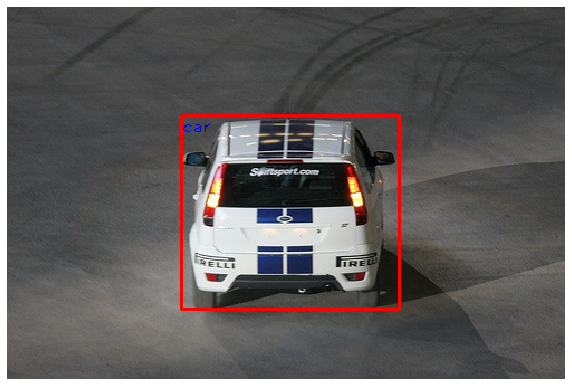

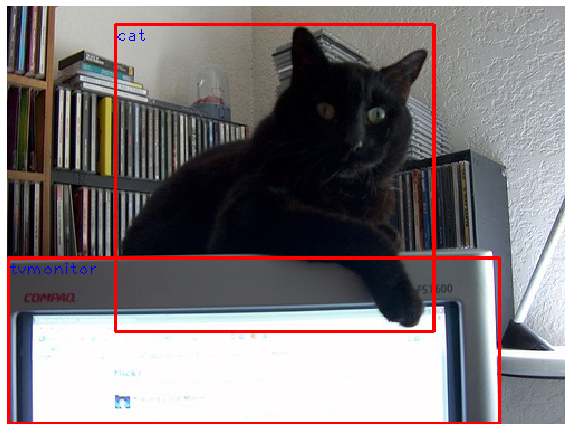

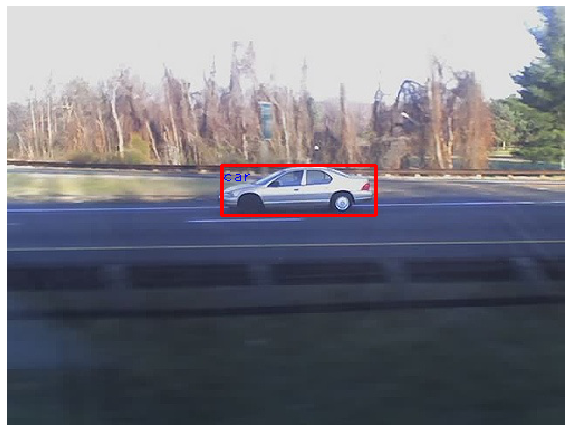

In [ ]:
# visualize GT boxes
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  data_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# Region Proposal Networks (RPN)
The first stage in a Faster R-CNN object detector is the *Region Proposal Network (RPN)*. The RPN classifies a set of anchors as either containing an object or not, and also regresses from the position of the anchor box to a region proposal.

The RPN is very similar to the single-stage detector we built in the previous notebook, except that it will not predict classification scores. We can therefore reuse many of the functions from the previous notebook in order to implement the RPN.

## Anchor
We will use the exact same set of anchors as in the single-stage detector from the previous notebook.

In [ ]:
# Declare variables for anchor priors, a Ax2 Tensor where A is the number of anchors.
# Hand-picked, same as our two-stage detector.
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]], **to_float_cuda)
print(anchor_list.shape)

torch.Size([9, 2])


## Activated (positive) and negative anchors
When training the RPN, we compare the anchor boxes with the ground-truth boxes in order to determine a ground-truth label for the anchor boxes -- should each anchor predict object or background?

We assign a positive label to two kinds of anchors:

(i) the anchor/anchors with the highest Intersection-overUnion (IoU) overlap with a ground-truth box, or

(ii) an anchor that has an IoU overlap higher than 0.7 with any ground-truth box. Note that a single ground-truth box may assign positive labels to multiple anchors.

Usually the second condition is sufficient to determine the positive samples; but we still adopt the first condition for the reason that in some rare cases the second condition may find no positive sample.

We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. Anchors that are neither positive nor negative do not contribute to the training objective

We can implement anchor generation and matching to ground-truth by reusing the `GenerateGrid`, `GenerateAnchor`, `IoU`, and `ReferenceOnActivatedAnchors` functions from the previous notebook.

Run the following to check the implementation from A5-1 (with your IoU function). You should see errors on the order of 1e-7 or less.

In [ ]:
fix_random_seed(0)

grid_list = GenerateGrid(w_list.shape[0])
anc_list = GenerateAnchor(anchor_list, grid_list)
iou_mat = IoU(anc_list, resized_box_list)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, resized_box_list, grid_list, iou_mat)

expected_GT_conf_scores = torch.tensor([0.74538743, 0.72793430, 0.71128041, 0.70029843,
                                        0.75670898, 0.76044953, 0.37116671, 0.37116671], **to_float_cuda)
expected_GT_offsets = torch.tensor([[ 0.01633334,  0.11911901, -0.09431065,  0.19244696],
                                    [-0.03675002,  0.09324861, -0.00250307,  0.25213102],
                                    [-0.03675002, -0.15675139, -0.00250307,  0.25213102],
                                    [-0.02940002,  0.07459889, -0.22564663,  0.02898745],
                                    [ 0.11879997,  0.03208542,  0.20863886, -0.07974572],
                                    [-0.08120003,  0.03208542,  0.20863886, -0.07974572],
                                    [ 0.07699990,  0.28533328, -0.03459148, -0.86750042],
                                    [ 0.07699990, -0.21466672, -0.03459148, -0.86750042]], **to_float_cuda)
expected_GT_class = torch.tensor([ 6,  7,  7,  7, 19, 19,  6,  6], **to_long_cuda)
print('conf scores error: ', rel_error(GT_conf_scores, expected_GT_conf_scores))
print('offsets error: ', rel_error(GT_offsets, expected_GT_offsets))
print('class prob error: ', rel_error(GT_class, expected_GT_class))

number of pos proposals:  8
conf scores error:  0.0
offsets error:  7.441442448907765e-07
class prob error:  0


********************************************************************************
Activated (positive) anchors:
1 activated anchors!


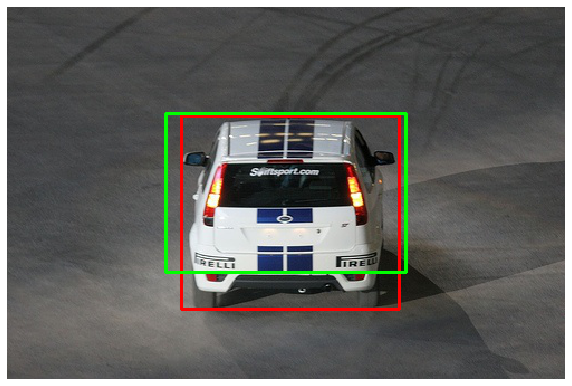

5 activated anchors!


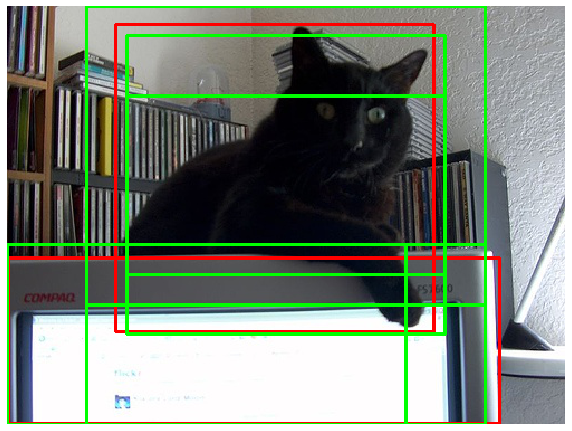

2 activated anchors!


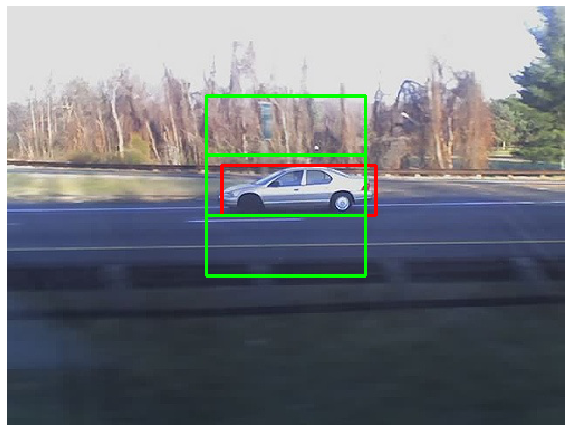

********************************************************************************
Negative anchors:
3 negative anchors!


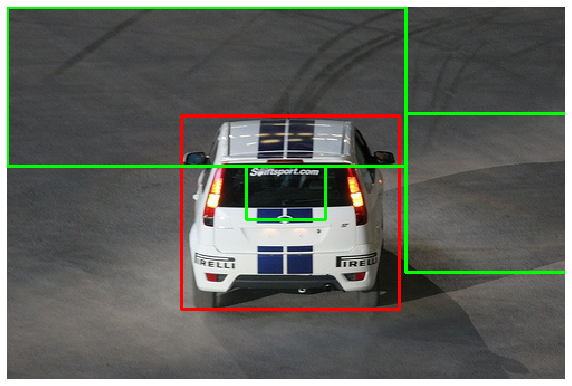

2 negative anchors!


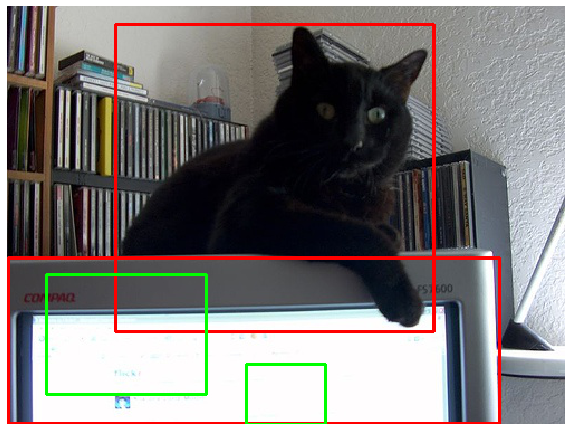

3 negative anchors!


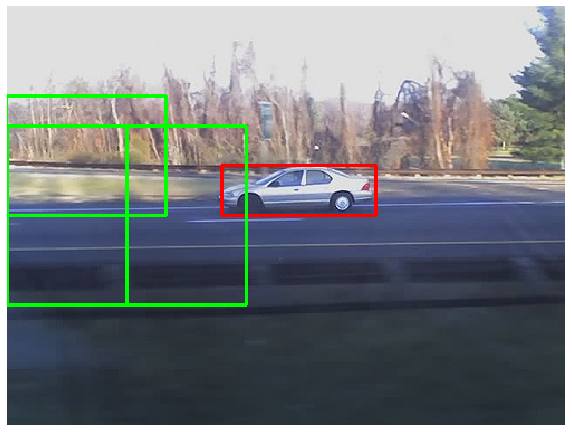

In [ ]:
# visualize the activated anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
  print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

## Proposal module
Similar to the Prediction Networks in A5-1, but for RPN you only need to predict the object proposal scores (from the *cls* layer) and bounding box offsets (from the *reg* layer), all of which are class-agnostic.

![pred_scores2](https://miro.medium.com/max/918/1*wB3ctS9WGNmw6pP_kjLjgg.png)

Note that here $k$ is essentially $A$. Image credit: Ren et al, "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks", NeurIPS 2015, https://arxiv.org/abs/1506.01497

In [ ]:
class ProposalModule(nn.Module):
  def __init__(self, in_dim, hidden_dim=256, num_anchors=9, drop_ratio=0.3):
    super().__init__()

    assert(num_anchors != 0)
    self.num_anchors = num_anchors
    ##############################################################################
    # TODO: Define the region proposal layer - a sequential module with a 3x3    #
    # conv layer, followed by a Dropout (p=drop_ratio), a Leaky ReLU and         #
    # a 1x1 conv.                                                                #
    # HINT: The output should be of shape Bx(Ax6)x7x7, where A=self.num_anchors. #
    #       Determine the padding of the 3x3 conv layer given the output dim.    #
    ##############################################################################
    # Replace "pass" statement with your code
    self.predictHead = nn.Sequential(
          nn.Conv2d(in_dim,hidden_dim,3,padding=1),
          nn.Dropout(drop_ratio),
          nn.LeakyReLU(),
          nn.Conv2d(hidden_dim,6*self.num_anchors,1)
        )
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def _extract_anchor_data(self, anchor_data, anchor_idx):
    """
    Inputs:
    - anchor_data: Tensor of shape (B, A, D, H, W) giving a vector of length
      D for each of A anchors at each point in an H x W grid.
    - anchor_idx: int64 Tensor of shape (M,) giving anchor indices to extract

    Returns:
    - extracted_anchors: Tensor of shape (M, D) giving anchor data for each
      of the anchors specified by anchor_idx.
    """
    B, A, D, H, W = anchor_data.shape
    anchor_data = anchor_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
    extracted_anchors = anchor_data[anchor_idx]
    return extracted_anchors

  def forward(self, features, pos_anchor_coord=None, \
              pos_anchor_idx=None, neg_anchor_idx=None):
    """
    Run the forward pass of the proposal module.

    Inputs:
    - features: Tensor of shape (B, in_dim, H', W') giving features from the
      backbone network.
    - pos_anchor_coord: Tensor of shape (M, 4) giving the coordinates of
      positive anchors. Anchors are specified as (x_tl, y_tl, x_br, y_br) with
      the coordinates of the top-left corner (x_tl, y_tl) and bottom-right
      corner (x_br, y_br). During inference this is None.
    - pos_anchor_idx: int64 Tensor of shape (M,) giving the indices of positive
      anchors. During inference this is None.
    - neg_anchor_idx: int64 Tensor of shape (M,) giving the indicdes of negative
      anchors. During inference this is None.

    The outputs from this module are different during training and inference.
    
    During training, pos_anchor_coord, pos_anchor_idx, and neg_anchor_idx are
    all provided, and we only output predictions for the positive and negative
    anchors. During inference, these are all None and we must output predictions
    for all anchors.

    Outputs (during training):
    - conf_scores: Tensor of shape (2M, 2) giving the classification scores
      (object vs background) for each of the M positive and M negative anchors.
    - offsets: Tensor of shape (M, 4) giving predicted transforms for the
      M positive anchors.If a single Tensor is passed, then the first column should contain the batch index.
    - proposals: Tensor of shaIf a single Tensor is passed, then the first column should contain the batch index.pe (M, 4) giving predicted region proposals for
      the M positive anchors.If a single Tensor is passed, then the first column should contain the batch index.

    Outputs (during inference):
    - conf_scores: Tensor of shape (B, A, 2, H', W') giving the predicted
      classification scores (object vs background) for all anchors
    - offsets: Tensor of shape (B, A, 4, H', W') giving the predicted transforms
      for all anchors
    """
    if pos_anchor_coord is None or pos_anchor_idx is None or neg_anchor_idx is None:
      mode = 'eval'
    else:
      mode = 'train'
    conf_scores, offsets, proposals = None, None, None
    ############################################################################
    # TODO: Predict classification scores (object vs background) and transforms#
    # for all anchors. During inference, simply output predictions for all     #
    # anchors. During training, extract the predictions for only the positive  #
    # and negative anchors as described above, and also apply the transforms to#
    # the positive anchors to compute the coordinates of the region proposals. #
    #                                                                          #
    # HINT: You can extract information about specific proposals using the     #
    # provided helper function self._extract_anchor_data.                      #
    # HINT: You can compute proposal coordinates using the GenerateProposal    #
    # function from the previous notebook.                                     #
    ############################################################################
    # Replace "pass" statement with your code
    anchor_features=self.predictHead(features) #Bx(Ax6)x7x7
    # split features into conf_package and offsets_package
    B,_,H,W = anchor_features.shape
    anchor_features = anchor_features.reshape(B,self.num_anchors,6,H,W)
    conf_package = anchor_features[:,:,:2,:,:]
    offsets_package = anchor_features[:,:,2:,:,:]
    if mode == 'eval':
      conf_scores, offsets = conf_package, offsets_package
    else:
      # train mode
      extracted_conf_package_pos = self._extract_anchor_data(conf_package,pos_anchor_idx)
      extracted_conf_package_neg = self._extract_anchor_data(conf_package,neg_anchor_idx)
      conf_scores = torch.cat((extracted_conf_package_pos,extracted_conf_package_neg), dim=0)[:,0:2]
      
      offsets = self._extract_anchor_data(offsets_package,pos_anchor_idx)
      M,_=pos_anchor_coord.shape

      proposals = GenerateProposal(pos_anchor_coord.reshape(1,1,1,M,4),
                                   offsets.reshape(1,1,1,M,4),
                                   'FasterRCNN').reshape(M,4)
      
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    if mode == 'train':
      return conf_scores, offsets, proposals
    elif mode == 'eval':
      return conf_scores, offsets

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [ ]:
# sanity check
fix_random_seed(0)
prop_module = ProposalModule(1280, drop_ratio=0).to(**to_float_cuda)
features = torch.linspace(-10., 10., steps=3*1280*7*7, **to_float_cuda).view(3, 1280, 7, 7)
conf_scores, offsets, proposals = prop_module(features, activated_anc_coord, \
              pos_anchor_idx=activated_anc_ind, neg_anchor_idx=negative_anc_ind)

expected_conf_scores = torch.tensor([[-0.50843990,  2.62025023],
                                     [-0.55775326, -0.29983672],
                                     [-0.55796617, -0.30000290],
                                     [ 0.17819080, -0.42211828],
                                     [-0.51439995, -0.47708601],
                                     [-0.51439744, -0.47703803],
                                     [ 0.63225138,  2.71269488],
                                     [ 0.63224381,  2.71290708]], **to_float_cuda)
expected_offsets = torch.tensor([[ 1.62754285,  1.35253453, -1.85451591, -1.77882397],
                                 [-0.33651856, -0.14402901, -0.07458937, -0.27201492],
                                 [-0.33671042, -0.14398587, -0.07479107, -0.27199429],
                                 [ 0.06847382,  0.21062726,  0.09334904, -0.02446130],
                                 [ 0.16506940, -0.30296192,  0.29626080,  0.32173073],
                                 [ 0.16507357, -0.30302414,  0.29625297,  0.32169008],
                                 [ 1.59992146, -0.75236654,  1.66449440,  2.05138564],
                                 [ 1.60008609, -0.75249159,  1.66474164,  2.05162382]], **to_float_cuda)

print('conf scores error: ', rel_error(conf_scores[:8], expected_conf_scores))
print('offsets error: ', rel_error(offsets, expected_offsets))

conf scores error:  0.0
offsets error:  0.0


## Loss Function
The confidence score regression loss is for both activated/negative anchors while the bounding box regression loss loss is for activated anchors only.

### Confidence score regression


In [ ]:
def ConfScoreRegression(conf_scores, batch_size):
  """
  Binary cross-entropy loss

  Inputs:
  - conf_scores: Predicted confidence scores, of shape (2M, 2). Assume that the
    first M are positive samples, and the last M are negative samples.

  Outputs:
  - conf_score_loss: Torch scalar
  """
  # the target conf_scores for positive samples are ones and negative are zeros
  M = conf_scores.shape[0] // 2
  GT_conf_scores = torch.zeros_like(conf_scores)
  GT_conf_scores[:M, 0] = 1.
  GT_conf_scores[M:, 1] = 1.

  conf_score_loss = F.binary_cross_entropy_with_logits(conf_scores, GT_conf_scores, \
                                     reduction='sum') * 1. / batch_size
  return conf_score_loss

### Bounding box regression

In [ ]:
def BboxRegression(offsets, GT_offsets, batch_size):
  """"
  Use SmoothL1 loss as in Faster R-CNN

  Inputs:
  - offsets: Predicted box offsets, of shape (M, 4)
  - GT_offsets: GT box offsets, of shape (M, 4)
  
  Outputs:
  - bbox_reg_loss: Torch scalar
  """
  bbox_reg_loss = F.smooth_l1_loss(offsets, GT_offsets, reduction='sum') * 1. / batch_size
  return bbox_reg_loss

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [ ]:
conf_loss = ConfScoreRegression(conf_scores, features.shape[0])
reg_loss = BboxRegression(offsets, GT_offsets, features.shape[0])
print('conf loss: {:.4f}, reg loss: {:.4f}'.format(conf_loss, reg_loss))

loss_all = torch.tensor([conf_loss.data, reg_loss.data], **to_float_cuda)
expected_loss = torch.tensor([8.55673981, 5.10593748], **to_float_cuda)

print('loss error: ', rel_error(loss_all, expected_loss))

conf loss: 8.5567, reg loss: 5.1059
loss error:  0.0


## RPN module
Implement Region Proposal Network. Should resemble the `SingleStageDetector` module from A5-1, but without the class prediction.

In [ ]:
class RPN(nn.Module):
  def __init__(self):
    super().__init__()

    # READ ONLY
    self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]])
    self.feat_extractor = FeatureExtractor()
    self.prop_module = ProposalModule(1280, num_anchors=self.anchor_list.shape[0])

  def forward(self, images, bboxes, output_mode='loss'):
    """
    Training-time forward pass for the Region Proposal Network.

    Inputs:
    - images: Tensor of shape (B, 3, 224, 224) giving input images
    - bboxes: Tensor of ground-truth bounding boxes, returned from the DataLoader
    - output_mode: One of 'loss' or 'all' that determines what is returned:
      If output_mode is 'loss' then the output is:
      - total_loss: Torch scalar giving the total RPN loss for the minibatch
      If output_mode is 'all' then the output is:
      - total_loss: Torch scalar giving the total RPN loss for the minibatch
      - pos_conf_scores: Tensor of shape (M, 1) giving the object classification
        scores (object vs background) for the positive anchors
      - proposals: Tensor of shape (M, 4) giving the coordiantes of the region
        proposals for the positive anchors
      - features: Tensor of features computed from the backbone network
      - GT_class: Tensor of shape (M,) giving the ground-truth category label
        for the positive anchors.
      - pos_anchor_idx: Tensor of shape (M,) giving indices of positive anchors
      - neg_anchor_idx: Tensor of shape (M,) giving indices of negative anchors
      - anc_per_image: Torch scalar giving the number of anchors per image.
    
    Outputs: See output_mode

    HINT: The function ReferenceOnActivatedAnchors from the previous notebook
    can compute many of these outputs -- you should study it in detail:
    - pos_anchor_idx (also called activated_anc_ind)
    - neg_anchor_idx (also called negative_anc_ind)
    - GT_class
    """
    # weights to multiply to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 5 # for offsets

    assert output_mode in ('loss', 'all'), 'invalid output mode!'
    total_loss = None
    conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img = \
      None, None, None, None, None, None
    ##############################################################################
    # TODO: Implement the forward pass of RPN.                                   #
    # A few key steps are outlined as follows:                                   #
    # i) Image feature extraction,                                               #
    # ii) Grid and anchor generation,                                            #
    # iii) Compute IoU between anchors and GT boxes and then determine activated/#
    #      negative anchors, and GT_conf_scores, GT_offsets, GT_class,           #
    # iv) Compute conf_scores, offsets, proposals through the region proposal    #
    #     module                                                                 #
    # v) Compute the total_loss for RPN which is formulated as:                  #
    #    total_loss = w_conf * conf_loss + w_reg * reg_loss,                     #
    #    where conf_loss is determined by ConfScoreRegression, w_reg by          #
    #    BboxRegression. Note that RPN does not predict any class info.          #
    #    We have written this part for you which you've already practiced earlier#
    # HINT: Do not apply thresholding nor NMS on the proposals during training   #
    #       as positive/negative anchors have been explicitly targeted.          #
    ##############################################################################
    # Replace "pass" statement with your code
    # i) Image feature extraction
    features = self.feat_extractor(images)

    # ii) Grid and anchor generation
    batch_size = images.shape[0]
    grid = GenerateGrid(batch_size)
    # anchors = GenerateAnchor(self.anchor_list.cuda(), grid) 
    anchors = GenerateAnchor(self.anchor_list.to(grid.device, grid.dtype), grid) # why this affects the # of proposals

    # iii-1) Compute IoU between anchors and GT boxes
    iou_mat = IoU(anchors, bboxes)
    # iii-2) determine activated & negative anchors, and GT_offsets, GT_class
    pos_anchor_idx, negative_anc_ind, _, GT_offsets, GT_class, activated_anc_coord,_ = \
      ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat,method='FasterRCNN')

    # iv) Compute conf_scores, offsets, proposals through the prediction network
    conf_scores, offsets, proposals = self.prop_module(features,activated_anc_coord, 
                                                       pos_anchor_idx, negative_anc_ind)
    anc_per_img = torch.prod(torch.tensor(anchors.shape[1:-1]))

    # v) Compute total loss
    conf_loss = ConfScoreRegression(conf_scores, features.shape[0]) # conf_loss
    reg_loss = BboxRegression(offsets, GT_offsets, features.shape[0]) # reg_loss
    total_loss = w_conf * conf_loss + w_reg * reg_loss

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    if output_mode == 'loss':
      return total_loss
    else:
      return total_loss, conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img


  def inference(self, images, thresh=0.5, nms_thresh=0.7, mode='RPN'):
    """
    Inference-time forward pass for the Region Proposal Network.

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - thresh: Threshold value on confidence scores. Proposals with a predicted
      object probability above thresh should be kept. HINT: You can convert the
      object score to an object probability using a sigmoid nonlinearity.
    - nms_thresh: IoU threshold for non-maximum suppression
    - mode: One of 'RPN' or 'FasterRCNN' to determine the outputs.

    The region proposal network can output a variable number of region proposals
    per input image. We assume that the input image images[i] gives rise to
    P_i final propsals after thresholding and NMS.

    NOTE: NMS is performed independently per-image!

    Outputs:
    - final_proposals: List of length B, where final_proposals[i] is a Tensor
      of shape (P_i, 4) giving the coordinates of the predicted region proposals
      for the input image images[i].
    - final_conf_probs: List of length B, where final_conf_probs[i] is a
      Tensor of shape (P_i,) giving the predicted object probabilities for each
      predicted region proposal for images[i]. Note that these are
      *probabilities*, not scores, so they should be between 0 and 1.
    - features: Tensor of shape (B, D, H', W') giving the image features
      predicted by the backbone network for each element of images.
      If mode is "RPN" then this is a dummy list of zeros instead.
    """
    assert mode in ('RPN', 'FasterRCNN'), 'invalid inference mode!'

    features, final_conf_probs, final_proposals = None, None, None
    ##############################################################################
    # TODO: Predicting the RPN proposal coordinates `final_proposals` and        #
    # confidence scores `final_conf_probs`.                                     #
    # The overall steps are similar to the forward pass but now you do not need  #
    # to decide the activated nor negative anchors.                              #
    # HINT: Threshold the conf_scores based on the threshold value `thresh`.     #
    # Then, apply NMS to the filtered proposals given the threshold `nms_thresh`.#
    ##############################################################################
    # Replace "pass" statement with your code
    final_conf_probs, final_proposals = [],[]
    # i) Image feature extraction
    features = self.feat_extractor(images)

    # ii) Grid and anchor generation
    batch_size = images.shape[0]
    grid = GenerateGrid(batch_size)
    # anchors = GenerateAnchor(self.anchor_list.cuda(), grid)
    anchors = GenerateAnchor(self.anchor_list.to(grid.device, grid.dtype), grid)

    # iii) Compute conf_scores, proposals, class_prob through the prediction network
    conf_scores, offsets = self.prop_module(features) 
    #offsets: (B, A, 4, H', W')
    #conf_scores: (B, A, 2, H', W')
    B,A,_,H,W = conf_scores.shape
    
    offsets = offsets.permute((0,1,3,4,2))
    proposals = GenerateProposal(anchors, offsets, method='FasterRCNN') #proposals:B,A,H,W,4
    # transform
    conf_scores = torch.sigmoid(conf_scores[:,:,0,:,:]) # only look at the 1st confidence score which represent obj_conf
    conf_scores = conf_scores.permute((0,2,3,1)).reshape(batch_size,-1)
    proposals = proposals.permute((0,2,3,1,4)).reshape(batch_size,-1,4)

    for i in range(batch_size):
      # get proposals, confidence scores for i-th image
      sub_conf_scores = conf_scores[i]
      sub_proposals = proposals[i]
      
      # filter by conf_scores
      mask1 = sub_conf_scores > thresh
      sub_conf_scores = sub_conf_scores[mask1]
      sub_proposals = sub_proposals[mask1,:]

      # filter by nms
      mask2 = nms(sub_proposals, sub_conf_scores, iou_threshold=nms_thresh)
      # append result
      final_proposals.append(sub_proposals[mask2,:])
      final_conf_probs.append(sub_conf_scores[mask2].unsqueeze(1))

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    if mode == 'RPN':
      features = [torch.zeros_like(i) for i in final_conf_probs] # dummy class
    return final_proposals, final_conf_probs, features

## RPN solver
In Faster R-CNN, the RPN is trained jointly with the second-stage network. However, to test our RPN implementation, we will first train just the RPN; this is basically a class-agnostic single-stage detector, that only classifies regions as object or background.

In [ ]:
RPNSolver = DetectionSolver # the same solver as in YOLO

## RPN - Overfit small data
First we will overfit the RPN on a small subset of the PASCAL VOC 2007 dataset. After training you should see a loss around or less than 3.0.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
  0%|          | 0.00/13.6M [00:00<?, ?B/s]

lr:  0.001


100%|██████████| 13.6M/13.6M [00:00<00:00, 18.9MB/s]


number of pos proposals:  50
(Iter 0 / 1)
(Epoch 0 / 200) loss: 30.4296 time per epoch: 0.2s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 1 / 200) loss: 59.7316 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 2 / 200) loss: 25.3708 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 3 / 200) loss: 20.5337 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 4 / 200) loss: 18.7835 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 5 / 200) loss: 17.6449 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 6 / 200) loss: 16.6990 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 7 / 200) loss: 15.7663 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 8 / 200) loss: 15.2408 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 9 / 200) loss: 14.9827 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 10 / 200) loss: 14.66

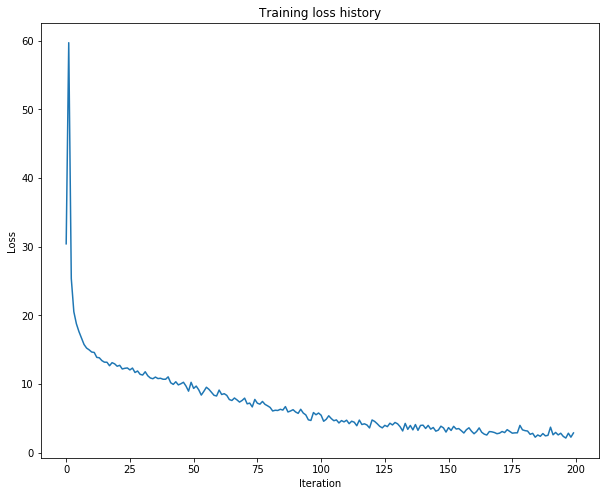

In [ ]:
# monitor the training loss
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-3]:
  print('lr: ', lr)
  rpn = RPN()
  RPNSolver(rpn, small_train_loader, learning_rate=lr, num_epochs=200)

## RPN - Inference
We will now visualize the predicted boxes from the RPN that we overfit to a small training sample. We will reuse the `DetectionInference` function from the previous notebook.

In [ ]:
RPNInference = DetectionInference

In [ ]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
# ignore the dummy object class (in blue) as RPN does not output class!
with torch.no_grad():
  RPNInference(rpn, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3)

# Faster R-CNN
We have implemented the first half of Faster R-CNN, i.e., RPN, which is class-agnostic. Here, we briefly describe the second half Fast R-CNN.

Given the proposals or region of interests (RoI) from RPN, we warp each region from CNN activation map to a fixed size 2x2 by using [RoI Align](https://arxiv.org/pdf/1703.06870.pdf). Essentially, the RoI feature is determined by bilinear interpolation over the CNN activation map. We meanpool the RoI feature over the spatial dimension (2x2).

Finally, we classify the meanpooled RoI feature into class probabilities.

For simplicity, our two-stage detector here differs from a full Faster R-CNN system in a few aspects.
1. In a full implementation, the second stage of the network would predict a second set of offsets to transform the region proposal into a final predicted object bounding box. However we omit this for simplicity.
2. In a full implementation, the second stage of the network should be able to reject negative boxes -- in other words, if we want to predict C different object categories then the final classification layer of the second stage would predict a distribution over C+1 categories, with an extra one for background. We omit this, as it requires extra bookeeping in the second stage about which proposals are positive / negative; so for simplicity our second stage will only predict a distribution over C categories, and we will assume that the RPN has filtered out all background regions.

## RoI Align
We will use the `roi_align` function from `torchvision`. Usage see https://pytorch.org/docs/stable/torchvision/ops.html#torchvision.ops.roi_align

## Faster R-CNN

In [ ]:
class TwoStageDetector(nn.Module):
  def __init__(self, in_dim=1280, hidden_dim=256, num_classes=20, \
               roi_output_w=2, roi_output_h=2, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0)
    self.num_classes = num_classes
    self.roi_output_w, self.roi_output_h = roi_output_w, roi_output_h
    ##############################################################################
    # TODO: Declare your RPN and the region classification layer (in Fast R-CNN).#
    # The region classification layer is a sequential module with a Linear layer,#
    # followed by a Dropout (p=drop_ratio), a ReLU nonlinearity and another      #
    # Linear layer that predicts classification scores for each proposal.        #
    # HINT: The dimension of the two Linear layers are in_dim -> hidden_dim and  #
    # hidden_dim -> num_classes.                                                 #
    ##############################################################################
    # Replace "pass" statement with your code
    self.rpn = RPN()
    self.classificationLayer = nn.Sequential(
          nn.Linear(in_dim,hidden_dim),
          nn.Dropout(drop_ratio),
          nn.ReLU(),
          nn.Linear(hidden_dim,self.num_classes)
        )
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

  def forward(self, images, bboxes):
    """
    Training-time forward pass for our two-stage Faster R-CNN detector.

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - bboxes: Tensor of shape (B, N, 5) giving ground-truth bounding boxes
      and category labels, from the dataloader.

    Outputs:
    - total_loss: Torch scalar giving the overall training loss.
    """
    total_loss = None
    ##############################################################################
    # TODO: Implement the forward pass of TwoStageDetector.                      #
    # A few key steps are outlined as follows:                                   #
    # i) RPN, including image feature extraction, grid/anchor/proposal           #
    #       generation, activated and negative anchors determination.            #
    # ii) Perform RoI Align on proposals and meanpool the feature in the spatial #
    #     dimension.                                                             #
    # iii) Pass the RoI feature through the region classification layer which    #
    #      gives the class probilities.                                          #
    # iv) Compute class_prob through the prediction network and compute the      #
    #     cross entropy loss (cls_loss) between the prediction class_prob and    #
    #      the reference GT_class. Hint: Use F.cross_entropy loss.               #
    # v) Compute the total_loss which is formulated as:                          #
    #    total_loss = rpn_loss + cls_loss.                                       #
    ##############################################################################
    # Replace "pass" statement with your code
    batch_size = images.shape[0]
    rpn_total_loss, conf_scores, proposals, features, GT_class, pos_anchor_idx, anc_per_img = \
      self.rpn(images, bboxes,'all') # proposals: M,4
    # roi_align: If a single Tensor is passed, then the first column should contain the batch index.
    
    batch_index = (pos_anchor_idx // anc_per_img).unsqueeze(1).to(proposals.dtype)# range is from 0-9
    proposals_w_batch_index = torch.cat((batch_index,proposals),dim=1) #[50,5]
    # print(proposals_w_batch_index)
    # print("features.shape=", features.shape) #[10, 1280, 7, 7]
    aligned_features = torchvision.ops.roi_align(features, proposals_w_batch_index, 
                                                 (self.roi_output_w, self.roi_output_h)) 
    #aligned_features: M,Channel,2,2
    # meanpool
    pooled_features = torch.mean(aligned_features,(2,3))

    # Pass the RoI feature through the region classification layer
    cls_scores = self.classificationLayer(pooled_features)
    # compute the cross entropy loss (cls_loss)
    # print("cls_scores.shape=",cls_scores.shape)
    # print("GT_class.shape=",GT_class.shape)
    # cls_loss = F.cross_entropy(cls_scores, GT_class) #cls_scores:(M,Cls); target:(M,)
    cls_loss = F.cross_entropy(cls_scores, GT_class, reduction='sum') * 1. / batch_size #This will boot performance by 2%

    total_loss = cls_loss + rpn_total_loss

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return total_loss

  def inference(self, images, thresh=0.5, nms_thresh=0.7):
    """"
    Inference-time forward pass for our two-stage Faster R-CNN detector

    Inputs:
    - images: Tensor of shape (B, 3, H, W) giving input images
    - thresh: Threshold value on NMS object probabilities
    - nms_thresh: IoU threshold for NMS in the RPN

    We can output a variable number of predicted boxes per input image.
    In particular we assume that the input images[i] gives rise to P_i final
    predicted boxes.

    Outputs:
    - final_proposals: List of length (B,) where final_proposals[i] is a Tensor
      of shape (P_i, 4) giving the coordinates of the final predicted boxes for
      the input images[i]
    - final_conf_probs: List of length (B,) where final_conf_probs[i] is a
      Tensor of shape (P_i,) giving the predicted probabilites that the boxes
      in final_proposals[i] are objects (vs background)
    - final_class: List of length (B,), where final_class[i] is an int64 Tensor
      of shape (P_i,) giving the predicted category labels for each box in
      final_proposals[i].
    """
    final_proposals, final_conf_probs, final_class = None, None, None
    ##############################################################################
    # TODO: Predicting the final proposal coordinates `final_proposals`,        #
    # confidence scores `final_conf_probs`, and the class index `final_class`.  #
    # The overall steps are similar to the forward pass but now you do not need #
    # to decide the activated nor negative anchors.                             #
    # HINT: Use the RPN inference function to perform thresholding and NMS, and #
    # to compute final_proposals and final_conf_probs. Use the predicted class  #
    # probabilities from the second-stage network to compute final_class.       #
    ##############################################################################
    # Replace "pass" statement with your code

    final_class=[]
    final_proposals, final_conf_probs, features = self.rpn.inference(images, thresh, 
                                                                     nms_thresh,mode='FasterRCNN')
    
    aligned_features = torchvision.ops.roi_align(features, final_proposals, 
                                                 (self.roi_output_w, self.roi_output_h))
    pooled_features = torch.mean(aligned_features,(2,3))
    cls_scores = self.classificationLayer(pooled_features)
    cls = torch.max(cls_scores,1)[1].to(torch.int64).unsqueeze(1)
    # slice cls into groups
    count = 0
    for i in range(len(final_proposals)):
      tmp_len=len(final_proposals[i])
      final_class.append(cls[count:count+tmp_len])
      count += tmp_len

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return final_proposals, final_conf_probs, final_class

## Overfit small data
We will now overfit the full Faster R-CNN network on a small subset of the training data. After training you should see a final loss less than 4.0.

number of pos proposals:  50
(Iter 0 / 1)
(Epoch 0 / 200) loss: 40.2167 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 1 / 200) loss: 61.7507 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 2 / 200) loss: 38.4958 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 3 / 200) loss: 33.0309 time per epoch: 0.2s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 4 / 200) loss: 30.6777 time per epoch: 0.2s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 5 / 200) loss: 29.0748 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 6 / 200) loss: 27.7376 time per epoch: 0.2s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 7 / 200) loss: 26.7676 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 8 / 200) loss: 25.9117 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 9 / 200) loss: 24.9268 time per epoch: 0.1s
number of pos proposals:  50
(Iter 0 / 1)
(Epoch 10 / 200) loss: 24.36

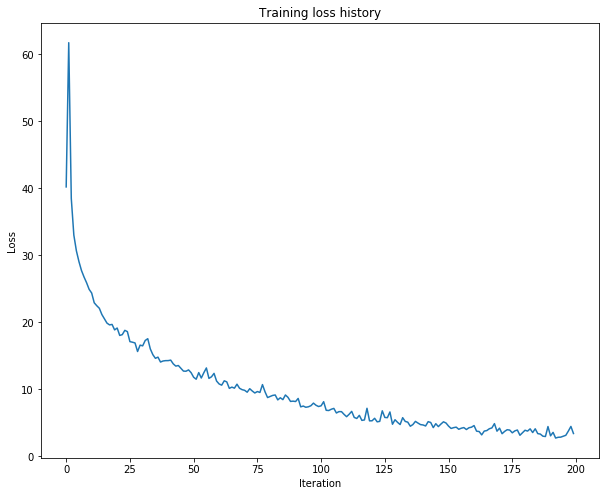

In [ ]:
# monitor the training loss

lr = 1e-3
detector = TwoStageDetector()
DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200)

### Inference

In [ ]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
with torch.no_grad():
  DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3)

## Train a net
Now it's time to train the full Faster R-CNN model on a larger subset of the the training data. We will train for 50 epochs; this should take about 35 minutes on a K80 GPU. You should see a total loss less than 3.0.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

number of pos proposals:  348
(Iter 0 / 25)
number of pos proposals:  410
(Iter 1 / 25)
number of pos proposals:  375
(Iter 2 / 25)
number of pos proposals:  362
(Iter 3 / 25)
number of pos proposals:  348
(Iter 4 / 25)
number of pos proposals:  316
(Iter 5 / 25)
number of pos proposals:  379
(Iter 6 / 25)
number of pos proposals:  362
(Iter 7 / 25)
number of pos proposals:  368
(Iter 8 / 25)
number of pos proposals:  363
(Iter 9 / 25)
number of pos proposals:  325
(Iter 10 / 25)
number of pos proposals:  355
(Iter 11 / 25)
number of pos proposals:  346
(Iter 12 / 25)
number of pos proposals:  363
(Iter 13 / 25)
number of pos proposals:  357
(Iter 14 / 25)
number of pos proposals:  349
(Iter 15 / 25)
number of pos proposals:  370
(Iter 16 / 25)
number of pos proposals:  367
(Iter 17 / 25)
number of pos proposals:  395
(Iter 18 / 25)
number of pos proposals:  386
(Iter 19 / 25)
number of pos proposals:  392
(Iter 20 / 25)
number of pos proposals:  405
(Iter 21 / 25)
number of pos propos

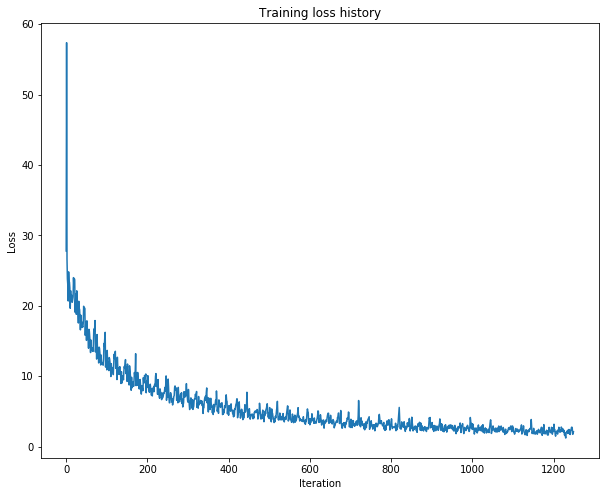

In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, 100) # a new loader

num_epochs = 50
lr = 5e-3
frcnn_detector = TwoStageDetector()
DetectionSolver(frcnn_detector, train_loader, learning_rate=lr, num_epochs=num_epochs)

In [ ]:
# (optional) load/save checkpoint
torch.save(frcnn_detector.state_dict(), 'frcnn_detector.pt') # uncomment to save your checkpoint
# frcnn_detector.load_state_dict(torch.load('frcnn_detector.pt')) # uncomment to load your previous checkpoint

### Inference

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
with torch.no_grad():
  DetectionInference(frcnn_detector, small_train_loader, small_dataset, idx_to_class)

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/498_FA2019_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 16% or above.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
!rm -r mAP/input/*
with torch.no_grad():
  DetectionInference(frcnn_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3)
# DetectionInference(frcnn_detector, train_loader, train_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3) # uncomment to see training mAP
!cd mAP && python main.py

rm: cannot remove 'mAP/input/*': No such file or directory
000005.jpg: 5 GT bboxes and 2 proposals
000007.jpg: 1 GT bboxes and 1 proposals
000009.jpg: 4 GT bboxes and 8 proposals
000016.jpg: 1 GT bboxes and 1 proposals
000019.jpg: 2 GT bboxes and 1 proposals
000020.jpg: 1 GT bboxes and 3 proposals
000021.jpg: 4 GT bboxes and 8 proposals
000024.jpg: 1 GT bboxes and 0 proposals
000030.jpg: 3 GT bboxes and 5 proposals
000039.jpg: 1 GT bboxes and 2 proposals
000041.jpg: 3 GT bboxes and 8 proposals
000046.jpg: 1 GT bboxes and 2 proposals
000050.jpg: 10 GT bboxes and 19 proposals
000051.jpg: 3 GT bboxes and 2 proposals
000052.jpg: 6 GT bboxes and 0 proposals
000060.jpg: 5 GT bboxes and 2 proposals
000063.jpg: 2 GT bboxes and 2 proposals
000065.jpg: 1 GT bboxes and 2 proposals
000072.jpg: 2 GT bboxes and 2 proposals
000081.jpg: 9 GT bboxes and 9 proposals
000093.jpg: 2 GT bboxes and 2 proposals
000095.jpg: 2 GT bboxes and 1 proposals
000099.jpg: 1 GT bboxes and 1 proposals
000101.jpg: 2 GT bb